In [2]:

import os
import torch
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('..')

from mix_NCA.MixtureNCANoise import MixtureNCANoise
from mix_NCA.NCA import NCA
from mix_NCA.MixtureNCA import MixtureNCA
from mix_NCA.utils_images import standard_update_net

In [1]:
def load_model(model_path, model_class, device="cuda"):
    """
    Load a saved model from path
    """
    # Load state dict
    state_dict = torch.load(model_path, map_location=device)

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    N_CHANNELS = 16  
    DROPOUT = 0.2
    HIDDEN_DIM = 128
    N_RULES = 6
      # Initialize models
    if model_class == NCA:

        model = NCA(update_net=standard_update_net(N_CHANNELS* 3, HIDDEN_DIM, N_CHANNELS, device=DEVICE), 
                state_dim=N_CHANNELS, 
                hidden_dim=HIDDEN_DIM, 
                dropout=DROPOUT, 
                device=DEVICE)
    elif model_class == MixtureNCA:
    
        model = MixtureNCA(update_nets=standard_update_net, 
                state_dim=N_CHANNELS, 
                num_rules = N_RULES,
                hidden_dim=HIDDEN_DIM, 
                dropout=DROPOUT, 
                device=DEVICE, temperature = 3)
    else:
        model = MixtureNCANoise(update_nets=standard_update_net, 
                    state_dim=N_CHANNELS, 
                    num_rules = N_RULES,
                    hidden_dim=HIDDEN_DIM, 
                    dropout=DROPOUT, 
                    device=DEVICE, temperature = 3)

    
    # Load state dict
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    
    return model

# Stability Lipschitz constant plots

In [3]:

import torch.nn as nn

def spectral_norm(weight: torch.Tensor) -> float:
    """
    Compute the spectral norm (largest singular value) of a weight tensor.
    For Linear layers: weight shape = (out_features, in_features)
    For Conv layers:   weight shape = (out_channels, in_channels, kH, kW, ...)
    We flatten so that the weight becomes a 2D matrix of shape (out_dim, in_dim).
    """
    W_mat = weight.reshape(weight.shape[0], -1)


    sigma = torch.linalg.norm(W_mat, ord=2)
    return sigma.item()

def lipschitz_constant(model: nn.Module) -> float:
    """
    Naive upper bound on the Lipschitz constant for a feed-forward
    network composed of Linear/Conv + pointwise activations like ReLU.
    It multiplies the spectral norms of all weight-carrying layers.
    """
    L = 1.0  # We'll multiply each layer's Lipschitz bound
    
    for layer in model.modules():
        # Check if this layer has a 'weight' parameter (e.g. Linear, Conv).
        if isinstance(layer, (nn.Linear, nn.Conv1d, nn.Conv2d, nn.Conv3d)):
            # Get the spectral norm of the weight
            W = layer.weight.data
            sigma = spectral_norm(W)
            L *= sigma

        elif isinstance(layer, (nn.ReLU, nn.LeakyReLU, nn.ELU, nn.SELU, nn.CELU)):
            pass

    return L

In [4]:
# Create a dictionary to store results for all emojis
emoji_results = {}
emoji_names = {
    "1F433": "Whale", 
    "1F984": "Unicorn",
    "1F620": "Angry",
    "1F951": "Avocado",
    "1F604": "Smile",
    "1F914": "Thinking"
}

for emoji_code in ["1F433", "1F984", "1F620", "1F951", "1F604", "1F914"]:
    results_dir = f"../results/experiment_{emoji_code}_robustness/"
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load models
    mixture_path = os.path.join(results_dir, "mixture_model.pt")
    nca_path = os.path.join(results_dir, "standard_model.pt")
    stochastic_mix_nca_path = os.path.join(results_dir, "gmix_model.pt")
    
    mix_nca = load_model(mixture_path, MixtureNCA, device)
    nca = load_model(nca_path, NCA, device)
    stochastic_mix_nca = load_model(stochastic_mix_nca_path, MixtureNCANoise, device)

    # Compute Lipschitz constants
    nca_lip = lipschitz_constant(nca.update)
    mix_lips = [lipschitz_constant(net) for net in mix_nca.update_nets]
    gmix_lips = [lipschitz_constant(net) for net in stochastic_mix_nca.update_nets]

    # Store results
    results = {
        'NCA': nca_lip,
        'MNCAmean': np.mean(mix_lips),
        'MNCAw/Noise_mean': np.mean(gmix_lips)
    }
    
    # Add individual rules
    for i, lip in enumerate(mix_lips):
        results[f'MNCA_{i+1}'] = lip
    for i, lip in enumerate(gmix_lips):
        results[f'sMNCA_w/Noise_{i+1}'] = lip
        
    emoji_results[emoji_names[emoji_code]] = results

# Create DataFrame
df = pd.DataFrame.from_dict(emoji_results, orient='index')

# Reorder columns to group by model type
standard_cols = ['NCA']
mix_cols = [col for col in df.columns if col.startswith('MNCA_')] 
stoch_cols = [col for col in df.columns if col.startswith('sMNCA_w/Noise_')] 
df = df[standard_cols + ['MNCAmean'] + ['MNCAw/Noise_mean'] + mix_cols + stoch_cols]

# Rename columns for clarity
new_columns = {
    'NCA': 'NCA',
    'MNCAmean': 'MNCA avg ',
    'MNCAw/Noise_mean': 'MNCA w/Noise avg'
}
for i in range(len(mix_cols)-1):
    new_columns[f'MNCA_{i+1}'] = f'MNCA {i+1}'
for i in range(len(stoch_cols)-1):
    new_columns[f'sMNCA_w/Noise_{i+1}'] = f'MNCA w/ Noise {i+1}'

df = df.rename(columns=new_columns)

# Round all values to 4 decimal places
df = df.round(4)

# Display the table
display(df)

# Optionally save to LaTeX
print("\nLaTeX table:")
print(df.to_latex(escape=False))
  


/tmp/ipykernel_3163258/3924815941.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


,NCA,MNCA avg,MNCA w/Noise avg,MNCA 1,MNCA 2,MNCA 3,MNCA 4,MNCA 5,MNCA_6,MNCA w/ Noise 1,MNCA w/ Noise 2,MNCA w/ Noise 3,MNCA w/ Noise 4,MNCA w/ Noise 5,sMNCA_w/Noise_6
Whale,4.8810,3.0230,3.0530,2.1908,1.9491,4.5959,2.5592,3.8551,2.9879,3.3571,3.8652,2.8662,1.9349,3.8990,2.3955
Unicorn,4.1101,2.9948,3.0371,2.0041,1.7963,3.5131,3.6568,3.4245,3.5740,2.6542,4.6250,2.2292,2.4133,3.2653,3.0353
Angry,4.4108,2.9899,3.1758,2.1521,1.8756,3.1047,3.1081,4.2370,3.4617,3.4942,3.6901,2.6694,2.1789,4.1142,2.9082
Avocado,4.3582,2.9540,2.9843,2.1538,3.2584,2.2672,3.6183,3.0064,3.4202,3.0049,1.9960,2.5180,3.7153,3.5192,3.1522
Smile,4.2934,2.9064,3.2662,1.8763,1.9940,3.4131,1.9903,4.8602,3.3047,3.3327,3.7102,3.0518,2.2298,4.6934,2.5794
Thinking,4.5554,2.9092,3.1628,2.0218,2.3767,3.0571,2.6874,3.8693,3.4430,3.1554,3.0269,2.4843,3.1600,3.9729,3.1772



LaTeX table:
\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
 & NCA & MNCA avg  & MNCA w/Noise avg & MNCA 1 & MNCA 2 & MNCA 3 & MNCA 4 & MNCA 5 & MNCA_6 & MNCA w/ Noise 1 & MNCA w/ Noise 2 & MNCA w/ Noise 3 & MNCA w/ Noise 4 & MNCA w/ Noise 5 & sMNCA_w/Noise_6 \\
\midrule
Whale & 4.881000 & 3.023000 & 3.053000 & 2.190800 & 1.949100 & 4.595900 & 2.559200 & 3.855100 & 2.987900 & 3.357100 & 3.865200 & 2.866200 & 1.934900 & 3.899000 & 2.395500 \\
Unicorn & 4.110100 & 2.994800 & 3.037100 & 2.004100 & 1.796300 & 3.513100 & 3.656800 & 3.424500 & 3.574000 & 2.654200 & 4.625000 & 2.229200 & 2.413300 & 3.265300 & 3.035300 \\
Angry & 4.410800 & 2.989900 & 3.175800 & 2.152100 & 1.875600 & 3.104700 & 3.108100 & 4.237000 & 3.461700 & 3.494200 & 3.690100 & 2.669400 & 2.178900 & 4.114200 & 2.908200 \\
Avocado & 4.358200 & 2.954000 & 2.984300 & 2.153800 & 3.258400 & 2.267200 & 3.618300 & 3.006400 & 3.420200 & 3.004900 & 1.996000 & 2.518000 & 3.715300 & 3.519200 & 3.152200 \\
Smile & 4.293400 & 2.906400 & 3

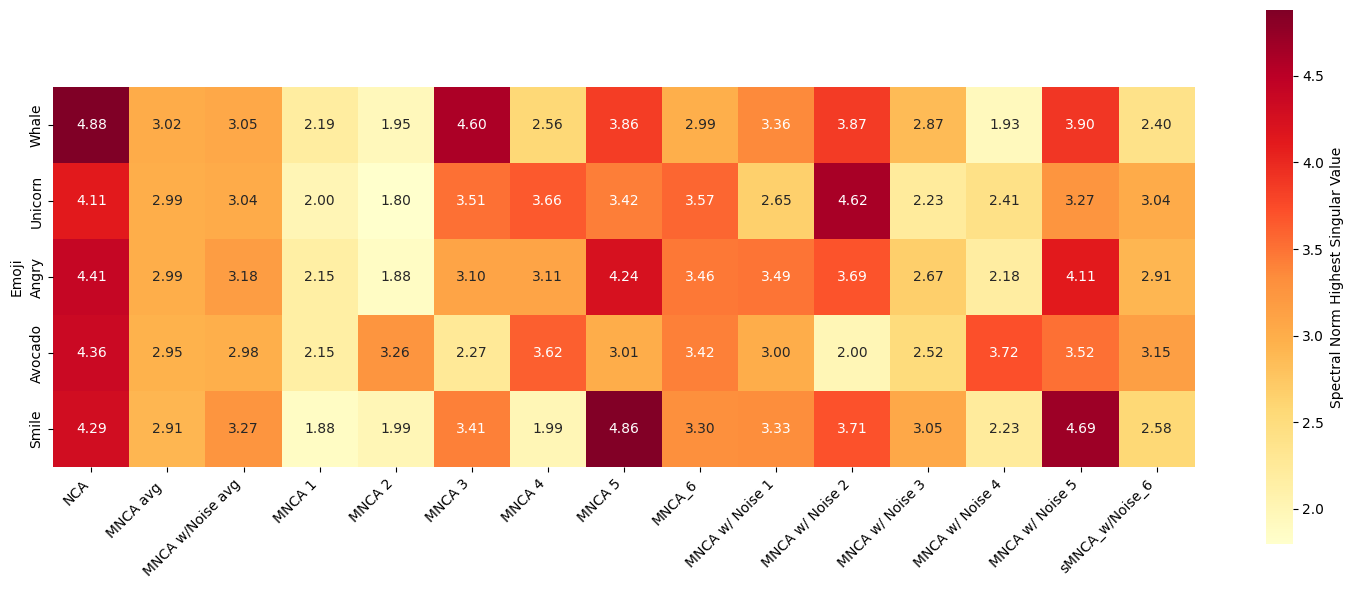

In [5]:
# Create emoji mapping
import matplotlib.font_manager as fm

# set the font to 
plt.rcParams['font.family'] = 'DejaVu Sans'


plt.figure(figsize=(15, 6))

# Create heatmap excluding the 'Mean' row
sns.heatmap(df.iloc[:-1], 
            cmap='YlOrRd',
            annot=True,     
            fmt='.2f',      
            cbar_kws={'label': 'Spectral Norm Highest Singular Value'},
            square=True)    

# Customize appearance
plt.title('', pad=20)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.ylabel('Emoji')

plt.tight_layout()

# save the figure
plt.savefig('../figures/lip_test_emoji.pdf', bbox_inches='tight', dpi=300, format='pdf')


plt.show()

# Reconstruction states plots


In [6]:
# Load noise results
noise_results = np.load("../results/experiment_1F433_robustness/noise_0.25.pkl", allow_pickle=True)


nca = load_model("../results/experiment_1F433_robustness/standard_model.pt", NCA, device="cuda")
mix_nca = load_model("../results/experiment_1F433_robustness/mixture_model.pt", MixtureNCA, device="cuda")
stochastic_mix_nca = load_model("../results/experiment_1F433_robustness/gmix_model.pt", MixtureNCANoise, device="cuda")
    

/tmp/ipykernel_3163258/3924815941.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


In [7]:
from mix_NCA.RobustnessAnalysis import  RobustnessAnalysis

ergo_results = [None]*50
init_state_nca = noise_results["init_state"]



# Robustness analysis 
robustness_analysis = RobustnessAnalysis(
standard_nca=nca.to("cuda")   ,
mixture_nca=mix_nca.to("cuda"),
stochastic_mixture_nca=stochastic_mix_nca.to("cuda"),
device="cuda"
)



for rep in range(50):
    ergo_results[rep] = robustness_analysis.compute_robustness_metrics(
                init_state_nca,
                'noise',
                n_runs=1,
                noise_level=0.25,
                steps=100,
                seed=(20,20)
        )
    



In [8]:
all_final_det = torch.stack([res["standard_recovery"][-1,0] for res in ergo_results])
all_final_mix = torch.stack([res["mixture_recovery"][-1,0] for res in ergo_results])
all_final_gmix = torch.stack([res["stochastic_recovery"][-1,0] for res in ergo_results])






In [14]:
import matplotlib.pyplot as plt

def plot_noise_recovery_grid(noise_data, ncols=10, figsize=(20, 20)):
    """
    Plot all images from noise_data in a grid
    Args:
        noise_data: tensor of shape [100, 1, a16, 52, 52]
        ncols: number of columns in the grid
        figsize: figure size
    """
    # Calculate number of rows needed
    nrows = (noise_data.shape[0] + ncols - 1) // ncols
    
    # Create figure
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    # Flatten axes for easier indexing
    axes_flat = axes.flatten()
    
    # Plot each image
    for i in range(noise_data.shape[0]):
        # Get image (take first channel, last timestep)
        img = torch.clip(noise_data[i, :4], 0, 1)
        
        # Plot
        axes_flat[i].imshow(img.cpu().numpy().transpose(1, 2, 0))
        axes_flat[i].axis('off')
        axes_flat[i].set_title(f'Sample {i}')
    
    # Turn off any empty subplots
    for i in range(noise_data.shape[0], len(axes_flat)):
        axes_flat[i].axis('off')
    
    plt.tight_layout()
    return fig

# Plot the grid
plt.rcParams['figure.dpi'] = 500
plt.rcParams['font.size'] = 15  # Smaller font size for many titles

fig = plot_noise_recovery_grid(all_final_det)

# Optionally save the figure
fig.savefig('../figures/noise_recovery_grid_whale.png', bbox_inches='tight', dpi=300)

In [10]:
# Load noise results
noise_results = np.load("../results/experiment_1F951_robustness/noise_0.25.pkl", allow_pickle=True)


nca = load_model("../results/experiment_1F951_robustness/standard_model.pt", NCA, device="cuda")
mix_nca = load_model("../results/experiment_1F951_robustness/mixture_model.pt", MixtureNCA, device="cuda")
stochastic_mix_nca = load_model("../results/experiment_1F951_robustness/gmix_model.pt", MixtureNCANoise, device="cuda")

/tmp/ipykernel_3163258/3924815941.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


In [11]:
from mix_NCA.RobustnessAnalysis import  RobustnessAnalysis

ergo_results = [None]*50
init_state_nca = noise_results["init_state"]



# Robustness analysis 
robustness_analysis = RobustnessAnalysis(
standard_nca=nca.to("cuda")   ,
mixture_nca=mix_nca.to("cuda"),
stochastic_mixture_nca=stochastic_mix_nca.to("cuda"),
device="cuda"
)



for rep in range(50):
    ergo_results[rep] = robustness_analysis.compute_robustness_metrics(
                init_state_nca,
                'noise',
                n_runs=1,
                noise_level=0.25,
                steps=100,
                seed=(20,20)
        )
    


In [12]:
all_final_det = torch.stack([res["standard_recovery"][-1,0] for res in ergo_results])
all_final_mix = torch.stack([res["mixture_recovery"][-1,0] for res in ergo_results])
all_final_gmix = torch.stack([res["stochastic_recovery"][-1,0] for res in ergo_results])


In [15]:
plt.rcParams['figure.dpi'] = 500
plt.rcParams['font.size'] = 15  # Smaller font size for many titles

fig = plot_noise_recovery_grid(all_final_det)

# Optionally save the figure
fig.savefig('../figures/noise_recovery_grid_avocado.png', bbox_inches='tight', dpi=300)